In [89]:
import goodfire
import matplotlib.pyplot as plt
import numpy as np
import os
import subprocess
import torch

from huggingface_hub import hf_hub_download
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

In [2]:
client = goodfire.Client(os.environ['GOODFIRE_API_KEY'])

#base_model = goodfire.Variant('meta-llama/Meta-Llama-3.1-8B-Instruct')
base_model = goodfire.Variant('meta-llama/Llama-3.3-70B-Instruct')

In [3]:
def load_activation(filename, shape=None, dtype=np.float32):
    """
    Load activation data from a binary file.
    
    Args:
        filename: Path to the .bin file
        shape: Tuple of tensor dimensions (if known)
        dtype: Data type of the tensor (default: float32)
    
    Returns:
        numpy array containing the activation data
    """
    # Read raw bytes
    with open(filename, 'rb') as f:
        data = f.read()
    
    # Convert to numpy array
    array = np.frombuffer(data, dtype=dtype)
    
    # Reshape if shape is provided
    if shape is not None:
        array = array.reshape(shape)
    
    return array

In [4]:
#SAE_NAME = 'Llama-3.1-8B-Instruct-SAE-l19'
SAE_NAME = 'Llama-3.3-70B-Instruct-SAE-l50'

file_path = hf_hub_download(
    repo_id=f"Goodfire/{SAE_NAME}",
    filename=f"{SAE_NAME}.pt",
    repo_type="model"
)

In [5]:
class SparseAutoEncoder(torch.nn.Module):
    def __init__(
        self,
        d_in: int,
        d_hidden: int,
        device: torch.device,
        dtype: torch.dtype = torch.float32,
    ):
        super().__init__()
        self.d_in = d_in
        self.d_hidden = d_hidden
        self.device = device
        self.encoder_linear = torch.nn.Linear(d_in, d_hidden)
        self.decoder_linear = torch.nn.Linear(d_hidden, d_in)
        self.dtype = dtype
        self.to(self.device, self.dtype)

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        """Encode a batch of data using a linear, followed by a ReLU."""
        return torch.nn.functional.relu(self.encoder_linear(x))

    def decode(self, x: torch.Tensor) -> torch.Tensor:
        """Decode a batch of data using a linear."""
        return self.decoder_linear(x)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """SAE forward pass. Returns the reconstruction and the encoded features."""
        f = self.encode(x)
        return self.decode(f), f


def load_sae(
    path: str,
    d_model: int,
    expansion_factor: int,
    device: torch.device = torch.device("cpu"),
):
    sae = SparseAutoEncoder(
        d_model,
        d_model * expansion_factor,
        device,
    )
    sae_dict = torch.load(
        path, weights_only=True, map_location=device
    )
    sae.load_state_dict(sae_dict)

    return sae

In [7]:
D_MODEL = 8192
EXPANSION_FACTOR = 8

In [8]:
sae = load_sae(
    file_path,
    d_model=D_MODEL,
    expansion_factor=EXPANSION_FACTOR,
    device=torch.device("cpu"),
)

In [44]:
def get_activations(prompt, model_width):
    cmd = [
        "./build/bin/llama-cli",
        "-m", "/Users/keenanpepper/Downloads/Llama-3.3-70B-Instruct-Q4_K_M.gguf",
        "--chat-template", "chatml",
        "-p", f"<|im_start|>user\n{prompt}",
        "-no-cnv",
        "-n", "1",
        "--gpu-layers", "0"
    ]

    subprocess.run(cmd, capture_output=True, text=True)

    n_embd_k_gqa = D_MODEL

    FILE_PATH = "activation.bin"

    # Load raw data first to determine n_tokens
    with open(FILE_PATH, 'rb') as f:
        data = f.read()
        
    # Calculate n_tokens based on file size and known dimension
    n_tokens = len(data) // (n_embd_k_gqa * np.dtype(np.float32).itemsize)
    shape = (n_tokens, n_embd_k_gqa)

    activations = load_activation(
        FILE_PATH,
        shape=shape,
        dtype=np.float32
    ).T

    return activations

In [80]:
activations = {}

In [82]:
for prompt in tqdm(["Purple", "Blue", "Red", "Green", "Yellow", "Orange", "Pink", "Brown", "Black", "White", "Gray", "Gold", "Silver"]):
#               "Turquoise", "Teal", "Lime", "Magenta", "Olive", "Maroon", "Navy", "Olive", "Mint", "Lilac", "Peach", "Plum", "Taupe", "Beige", "Khaki", "Coral", "Crimson", "Turquoise", "Teal", "Lime", "Magenta", "Olive", "Maroon", "Navy", "Olive", "Mint", "Lilac", "Peach", "Plum", "Taupe", "Beige", "Khaki", "Coral", "Crimson"]:
    activations[prompt] = get_activations(prompt, D_MODEL)

100%|██████████| 13/13 [13:28<00:00, 62.22s/it]


In [83]:
last_activations = {prompt: torch.tensor(activations[prompt][:,-1]) for prompt in activations}

In [47]:
color_features = client.features.search("the color blue", base_model)

In [50]:
color_features = color_features[:4]
color_features

FeatureGroup([
   0: "The color blue in literal/physical contexts",
   1: "The color red",
   2: "The color yellow",
   3: "The color white used as a visual descriptor"
])

In [62]:
more_features = client.features.neighbors(color_features, base_model, 20)

In [67]:
more_features[19]

Feature("silver as a material or color")

In [69]:
color_features.add(more_features[19])
color_features

FeatureGroup([
   0: "The color blue in literal/physical contexts",
   1: "The color red",
   2: "The color yellow",
   3: "The color white used as a visual descriptor",
   4: "The word pink appearing in text",
   5: "Green in aesthetic and descriptive contexts",
   6: "The color gray/grey, both literal and metaphorical",
   7: "Black as an intentional design or aesthetic choice",
   8: "The color brown used as a basic descriptor",
   ...
   10: "silver as a material or color"
])

In [87]:
[(f.label, torch.cosine_similarity(last_activations["Blue"], sae.decoder_linear.weight.data[:,f.index_in_sae], dim=0)) for f in color_features[:3]]

[('The color blue in literal/physical contexts', tensor(0.5967)),
 ('The color red', tensor(0.2253)),
 ('The color yellow', tensor(0.2153))]

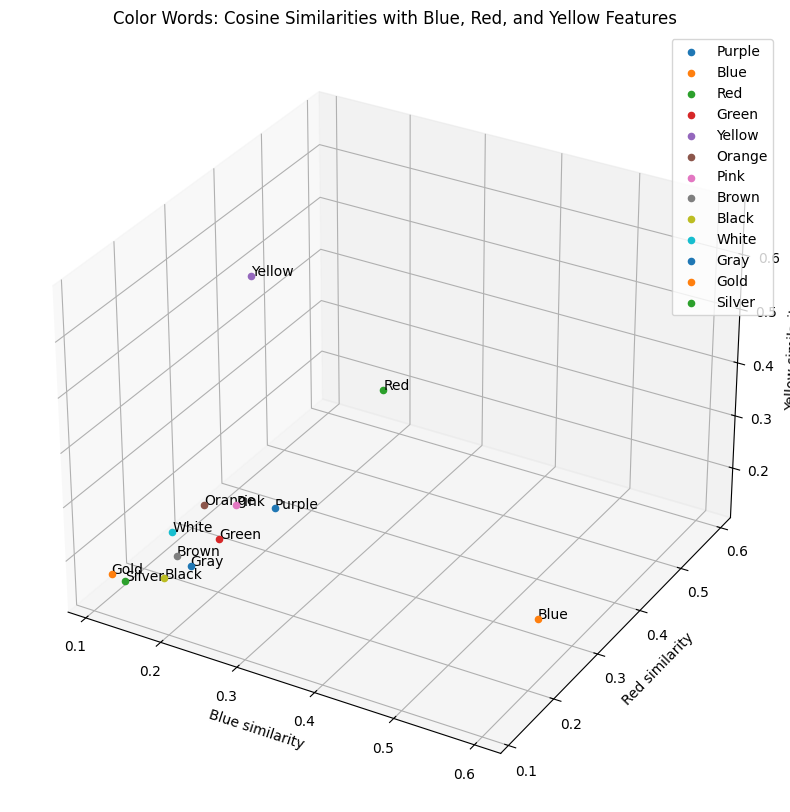

In [90]:
# Calculate cosine similarities for all colors
color_sims = {}
blue_feature = color_features[0]
red_feature = color_features[1]
yellow_feature = color_features[2]

for color_name, activation in last_activations.items():
    blue_sim = torch.cosine_similarity(activation, sae.decoder_linear.weight.data[:,blue_feature.index_in_sae], dim=0).item()
    red_sim = torch.cosine_similarity(activation, sae.decoder_linear.weight.data[:,red_feature.index_in_sae], dim=0).item()
    yellow_sim = torch.cosine_similarity(activation, sae.decoder_linear.weight.data[:,yellow_feature.index_in_sae], dim=0).item()
    color_sims[color_name] = (blue_sim, red_sim, yellow_sim)

# Create 3D scatter plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot each point
for color_name, (x, y, z) in color_sims.items():
    ax.scatter(x, y, z, label=color_name)
    ax.text(x, y, z, color_name)

# Set labels and title
ax.set_xlabel('Blue similarity')
ax.set_ylabel('Red similarity')
ax.set_zlabel('Yellow similarity')
ax.set_title('Color Words: Cosine Similarities with Blue, Red, and Yellow Features')

# Add legend
ax.legend()

plt.show()

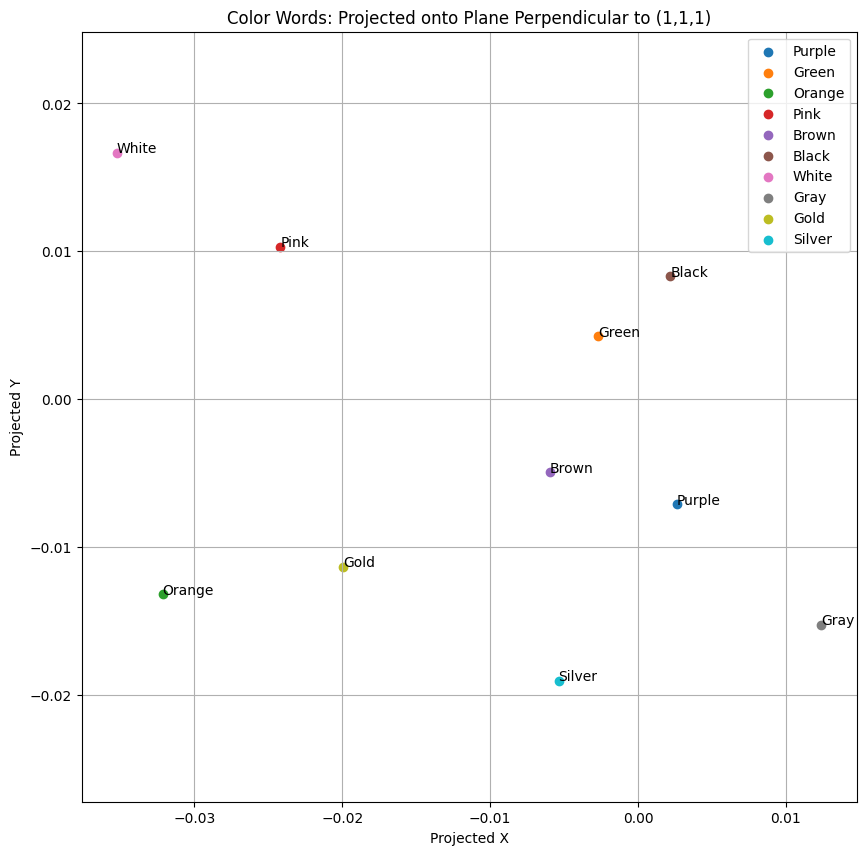

In [94]:
# Calculate cosine similarities for all colors (if not already done)
color_sims = {}
blue_feature = color_features[0]
red_feature = color_features[1]
yellow_feature = color_features[2]

for color_name, activation in last_activations.items():
    if color_name in ["Blue", "Red", "Yellow"]:
        continue
    blue_sim = torch.cosine_similarity(activation, sae.decoder_linear.weight.data[:,blue_feature.index_in_sae], dim=0).item()
    red_sim = torch.cosine_similarity(activation, sae.decoder_linear.weight.data[:,red_feature.index_in_sae], dim=0).item()
    yellow_sim = torch.cosine_similarity(activation, sae.decoder_linear.weight.data[:,yellow_feature.index_in_sae], dim=0).item()
    color_sims[color_name] = np.array([blue_sim, red_sim, yellow_sim])

# Define the (1,1,1) direction and normalize it
v_111 = np.array([1, 1, 1]) / np.sqrt(3)

# Project points onto the plane perpendicular to (1,1,1)
projected_points = {}
for color_name, point in color_sims.items():
    # Remove the component along (1,1,1)
    projection_111 = np.dot(point, v_111) * v_111
    projection_plane = point - projection_111
    projected_points[color_name] = projection_plane

# Create a 2D plot (since we're now on a plane)
plt.figure(figsize=(10, 10))

# Plot each projected point
for color_name, point in projected_points.items():
    # Use any two non-parallel directions in the plane as x and y coordinates
    # Here we'll use the projection onto the x-y plane
    plt.scatter(point[0], point[1], label=color_name)
    plt.annotate(color_name, (point[0], point[1]))

plt.xlabel('Projected X')
plt.ylabel('Projected Y')
plt.title('Color Words: Projected onto Plane Perpendicular to (1,1,1)')
plt.grid(True)
plt.legend()
plt.axis('equal')  # Make the plot aspect ratio 1:1
plt.show()

In [96]:
color_features[5]

Feature("Green in aesthetic and descriptive contexts")

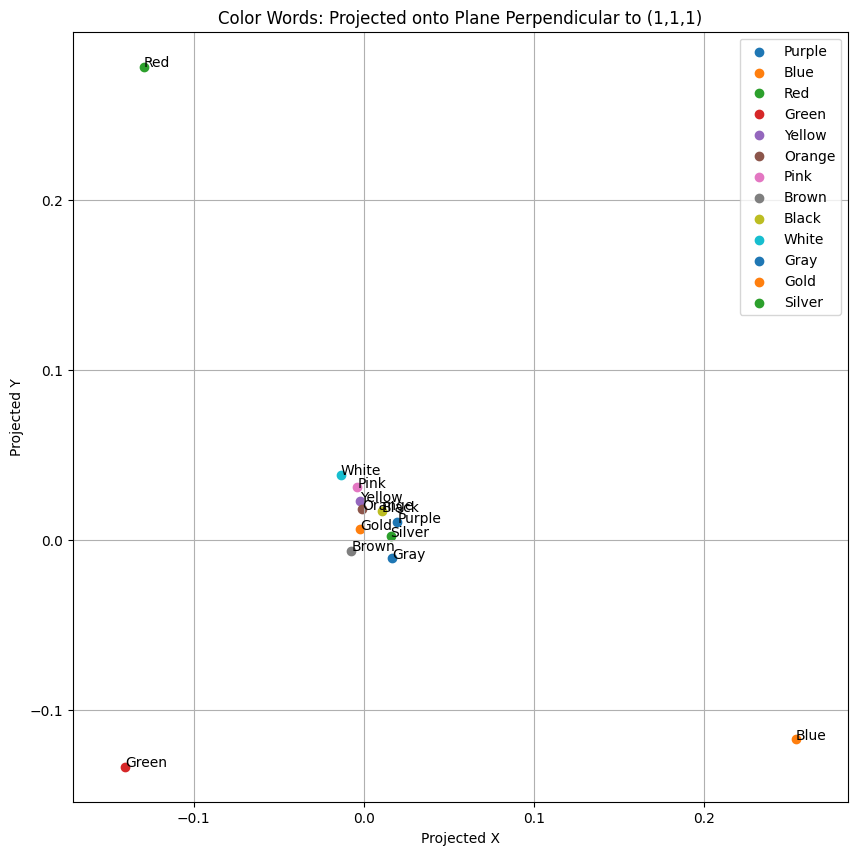

In [98]:
# Calculate cosine similarities for all colors (if not already done)
color_sims = {}
blue_feature = color_features[0]
red_feature = color_features[1]
green_feature = color_features[5]

for color_name, activation in last_activations.items():
    if color_name in ["Blue", "Red", "Green"]:
        pass
    blue_sim = torch.cosine_similarity(activation, sae.decoder_linear.weight.data[:,blue_feature.index_in_sae], dim=0).item()
    red_sim = torch.cosine_similarity(activation, sae.decoder_linear.weight.data[:,red_feature.index_in_sae], dim=0).item()
    green_sim = torch.cosine_similarity(activation, sae.decoder_linear.weight.data[:,green_feature.index_in_sae], dim=0).item()
    color_sims[color_name] = np.array([blue_sim, red_sim, green_sim])

# Define the (1,1,1) direction and normalize it
v_111 = np.array([1, 1, 1]) / np.sqrt(3)

# Project points onto the plane perpendicular to (1,1,1)
projected_points = {}
for color_name, point in color_sims.items():
    # Remove the component along (1,1,1)
    projection_111 = np.dot(point, v_111) * v_111
    projection_plane = point - projection_111
    projected_points[color_name] = projection_plane

# Create a 2D plot (since we're now on a plane)
plt.figure(figsize=(10, 10))

# Plot each projected point
for color_name, point in projected_points.items():
    # Use any two non-parallel directions in the plane as x and y coordinates
    # Here we'll use the projection onto the x-y plane
    plt.scatter(point[0], point[1], label=color_name)
    plt.annotate(color_name, (point[0], point[1]))

plt.xlabel('Projected X')
plt.ylabel('Projected Y')
plt.title('Color Words: Projected onto Plane Perpendicular to (1,1,1)')
plt.grid(True)
plt.legend()
plt.axis('equal')  # Make the plot aspect ratio 1:1
plt.show()

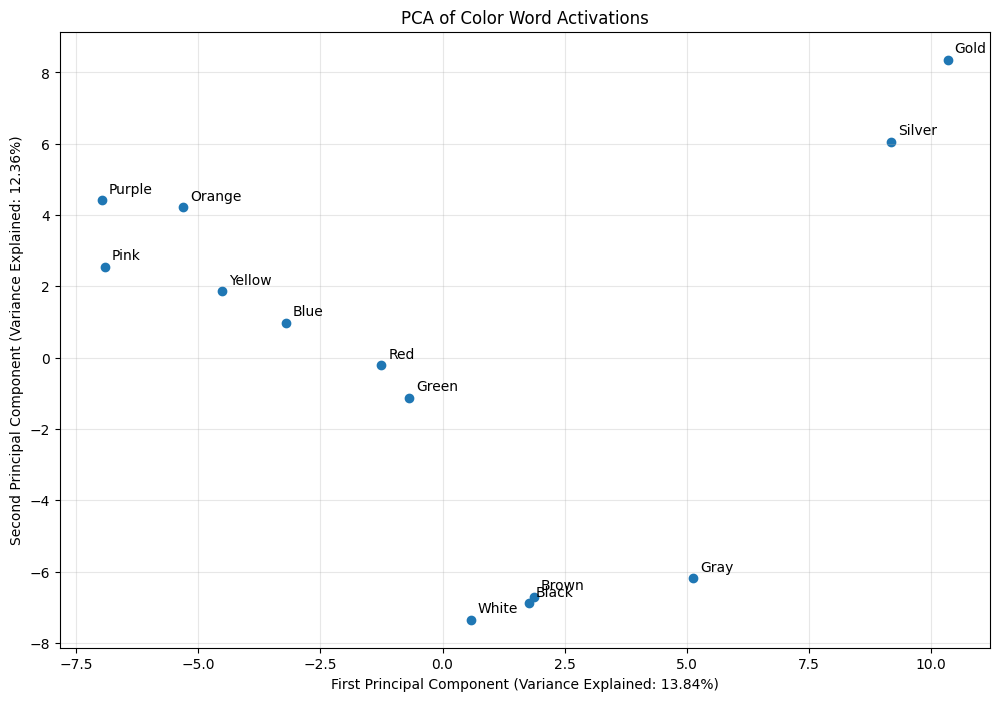

In [100]:
# Convert activations to a matrix for PCA
from sklearn.decomposition import PCA

# Stack all activation vectors into a matrix
X = np.stack([tensor.numpy() for tensor in last_activations.values()])
color_names = list(last_activations.keys())

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1])

# Add labels for each point
for i, color in enumerate(color_names):
    plt.annotate(color, (X_pca[i, 0], X_pca[i, 1]), 
                xytext=(5, 5), textcoords='offset points')

# Add title and labels
plt.title('PCA of Color Word Activations')
plt.xlabel(f'First Principal Component (Variance Explained: {pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'Second Principal Component (Variance Explained: {pca.explained_variance_ratio_[1]:.2%})')

# Add grid
plt.grid(True, alpha=0.3)

plt.show()

In [101]:
color_feature_unit_vectors = {f.label: sae.decoder_linear.weight.data[:,f.index_in_sae] / torch.norm(sae.decoder_linear.weight.data[:,f.index_in_sae]) for f in color_features}

In [122]:
color_features

FeatureGroup([
   0: "The color blue in literal/physical contexts",
   1: "The color red",
   2: "The color yellow",
   3: "The color white used as a visual descriptor",
   4: "The word pink appearing in text",
   5: "Green in aesthetic and descriptive contexts",
   6: "The color gray/grey, both literal and metaphorical",
   7: "Black as an intentional design or aesthetic choice",
   8: "The color brown used as a basic descriptor",
   ...
   10: "silver as a material or color"
])

In [132]:
smaller_subspace_representations = {k: torch.tensor([torch.dot(v, color_feature_unit_vectors[f.label]) for f in color_features[:6]]) for k, v in last_activations.items()}

In [133]:
smaller_subspace_representations["Purple"]

tensor([5.6557, 5.4371, 5.6982, 2.5758, 6.6370, 4.5337])

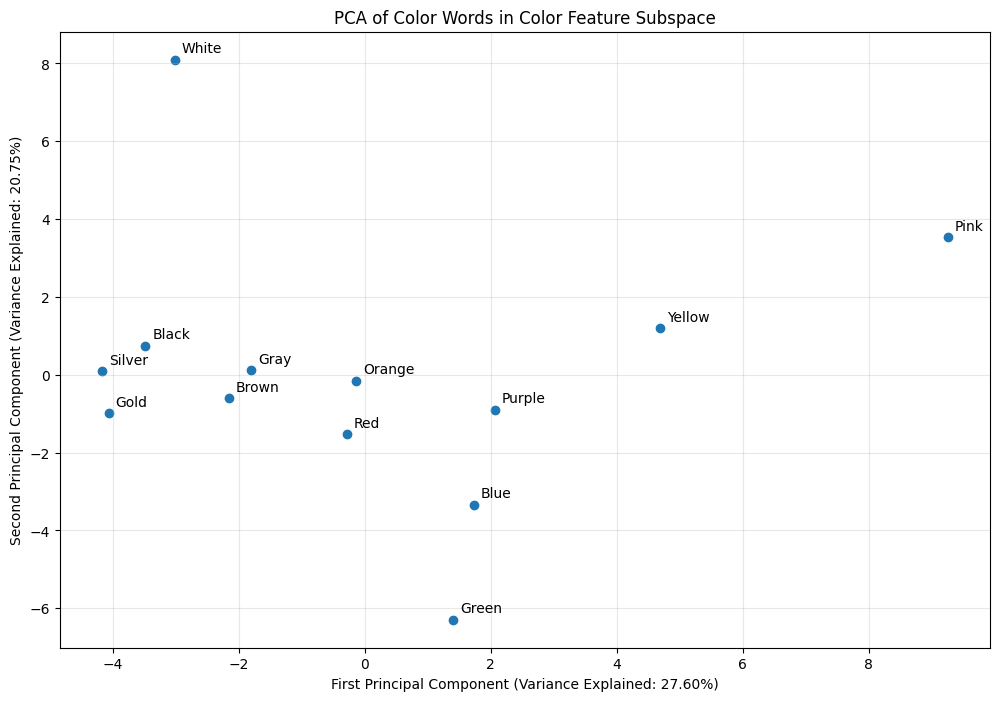

In [134]:
# Convert dictionary of tensors to numpy matrix
X = np.stack([tensor.numpy() for tensor in smaller_subspace_representations.values()])
color_names = list(smaller_subspace_representations.keys())

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1])

# Add labels for each point
for i, color in enumerate(color_names):
    plt.annotate(color, (X_pca[i, 0], X_pca[i, 1]), 
                xytext=(5, 5), textcoords='offset points')

# Add title and labels
plt.title('PCA of Color Words in Color Feature Subspace')
plt.xlabel(f'First Principal Component (Variance Explained: {pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'Second Principal Component (Variance Explained: {pca.explained_variance_ratio_[1]:.2%})')

# Add grid
plt.grid(True, alpha=0.3)

plt.show()